In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps
import time
import torch.nn as nn
# %matplotlib inline
import os
import torch
from torch.autograd import Variable
import math
dtype = torch.cuda.FloatTensor

In [15]:
class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def get_name(name):
    name[0] +=1
    return str(name[0])

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    name = [0]
    for i in range(len(c_down)):
        layer = nn.Sequential()
        layer.add_module(get_name(name),nn.Sequential(nn.Conv2d(input_depth, c_down[i], k_down, 2, padding=int((k_down - 1) / 2))))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        layer.add_module(get_name(name),nn.Sequential(nn.Conv2d(c_down[i], c_down[i], k_down, 1, padding=int((k_down - 1) / 2))))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            layer.add_module(get_name(name),deeper_main)
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Sequential(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2))))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add_module(get_name(name),nn.Sequential(nn.Conv2d(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1, padding=int((k_up - 1) / 2))))
            
        else:#last layer
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Sequential(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2))))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add_module(get_name(name),nn.Sequential(nn.Conv2d(c_skip[i] + c_down[i], c_up[i], k_up, 1, padding=int((k_up - 1) / 2))))

        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        model_tmp.add_module(get_name(name),nn.Sequential(nn.Conv2d(c_up[i], c_up[i], 1, 1)))
        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add_module(get_name(name),nn.Sequential(nn.Conv2d(c_up[0], c_out, 1, 1)))
    model.add_module(get_name(name),nn.Sigmoid())

    return model

In [16]:
def preprocess_input_with_mask(img, mask):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    mask = Image.open(mask)
    plt.figure()
    plt.imshow(mask,cmap='gray')
    img = np.array(img).transpose(2,0,1)
    print(img.shape)
    img = img[:3,:512,:512]/255
    mask = np.array(mask)[None, :]/255
    processed_img = img*mask
    plt.figure()
    plt.imshow(processed_img.transpose(1,2,0))
    img = (torch.from_numpy(img)[None,:]).type(dtype)
    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

In [17]:
def preprocess_input(img):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    img = np.array(img)
    print(img.shape)
    
    tmp = np.random.choice(512*512, 512*512//2)
    processed_img = img.copy()
    
    if len(img.shape)<3:
        
        img = img[:512,:512]/255
        mask = np.ones((512,512))
        for i in tmp:
            mask[i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask, cmap='gray')
        
        processed_img = img*mask
        
        plt.figure()
        plt.imshow(processed_img)
        
    else:
        img = np.array(img).transpose(2,0,1)
        img = img[:3,:512,:512]/255
        mask = np.ones((3,512,512))
        for i in tmp:
            mask[:,i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask.transpose(1,2,0))
        
        processed_img = img*mask
    
        plt.figure()
        plt.imshow(processed_img.transpose(1,2,0))

    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return mask, processed_img 

(512, 512)


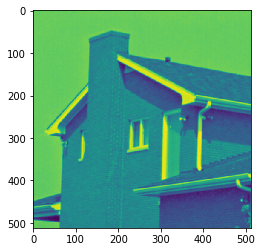

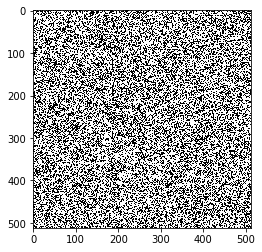

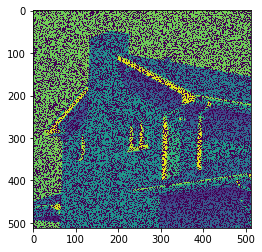

In [22]:
base_dir = 'inpainting_dataset/'
img = base_dir+'test_images/house.png'
# mask = base_dir+'justin_mask.png'
mask, processed_img = preprocess_input(img)

Iteration 00000  Loss 0.027518  PSNR 15.603817
3


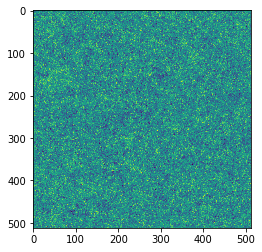

Iteration 00100  Loss 0.001556  PSNR 28.080953
3


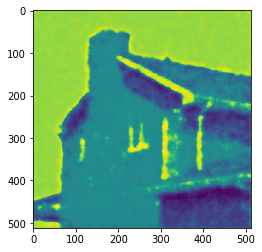

Iteration 00200  Loss 0.000732  PSNR 31.352508
3


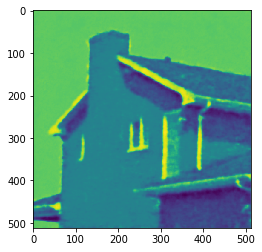

Iteration 00300  Loss 0.000476  PSNR 33.228272
3


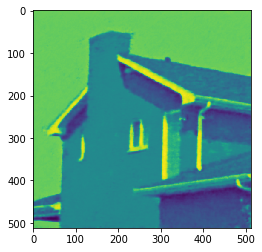

Iteration 00400  Loss 0.000355  PSNR 34.494672
3


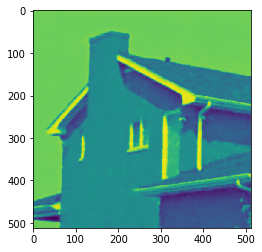

Iteration 00500  Loss 0.000276  PSNR 35.596530
3


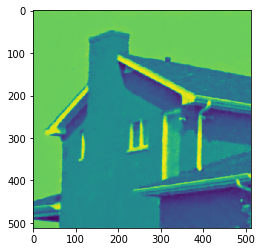

Iteration 00600  Loss 0.000238  PSNR 36.237582
3


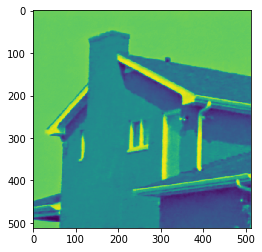

Iteration 00700  Loss 0.000202  PSNR 36.951315
3


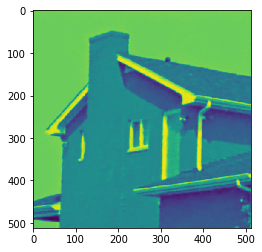

Iteration 00800  Loss 0.000185  PSNR 37.321046
3


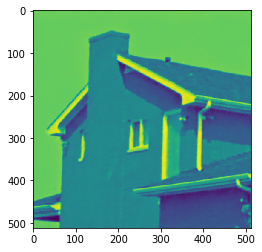

Iteration 00900  Loss 0.000169  PSNR 37.732552
3


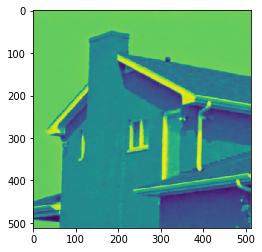

Iteration 01000  Loss 0.000150  PSNR 38.247051
3


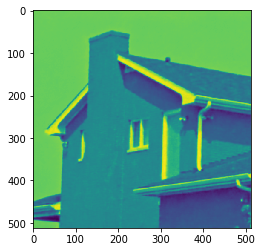

Iteration 01100  Loss 0.000136  PSNR 38.657378
3


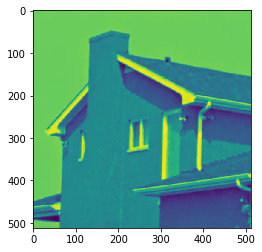

Iteration 01200  Loss 0.000129  PSNR 38.877561
3


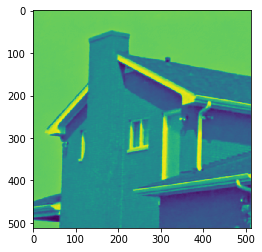

Iteration 01300  Loss 0.000163  PSNR 37.876496
3


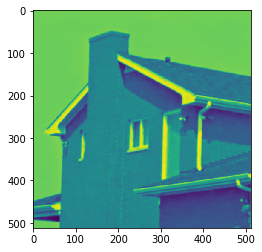

Iteration 01400  Loss 0.000106  PSNR 39.730306
3


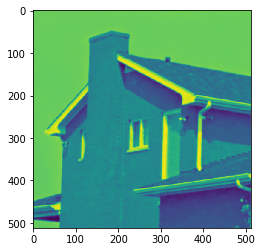

Iteration 01500  Loss 0.000108  PSNR 39.676942
3


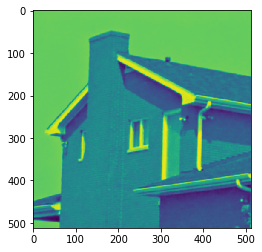

Iteration 01600  Loss 0.000096  PSNR 40.157100
3


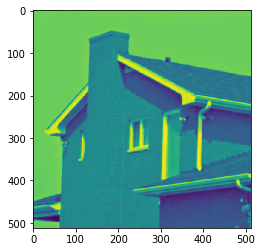

Iteration 01700  Loss 0.000094  PSNR 40.274897
3


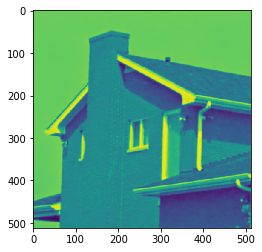

Iteration 01800  Loss 0.000086  PSNR 40.642324
3


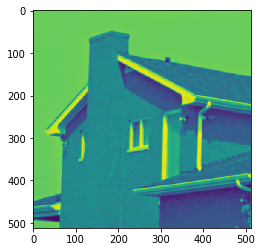

Iteration 01900  Loss 0.000079  PSNR 41.024187
3


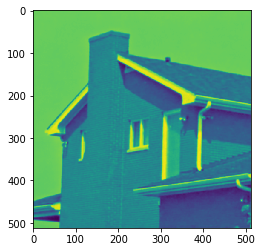

Iteration 02000  Loss 0.000070  PSNR 41.532257
3


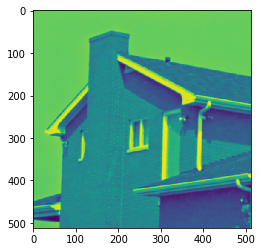

Iteration 02100  Loss 0.000065  PSNR 41.841986
3


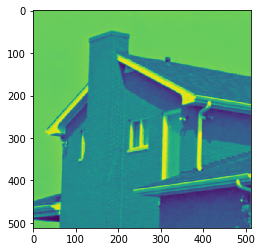

Iteration 02200  Loss 0.000064  PSNR 41.970636
3


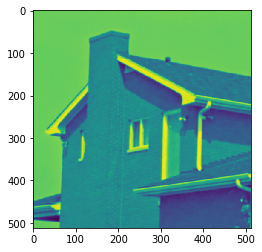

Iteration 02300  Loss 0.000062  PSNR 42.090808
3


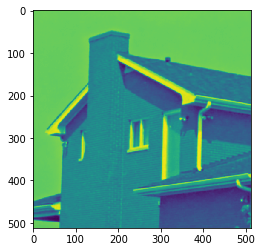

Iteration 02400  Loss 0.000060  PSNR 42.184635
3


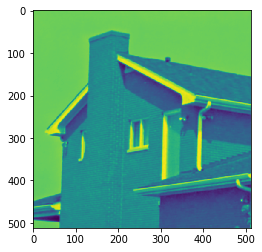

Iteration 02500  Loss 0.000055  PSNR 42.569248
3


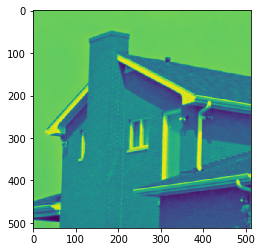

Iteration 02600  Loss 0.000057  PSNR 42.474822
3


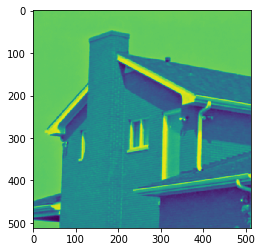

Iteration 02700  Loss 0.000048  PSNR 43.166665
3


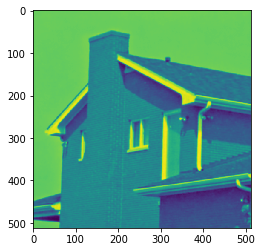

Iteration 02800  Loss 0.000048  PSNR 43.202384
3


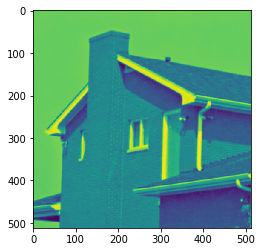

Iteration 02900  Loss 0.000048  PSNR 43.196546
3


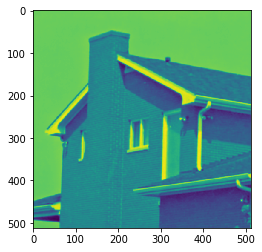

Iteration 03000  Loss 0.000048  PSNR 43.152301
3


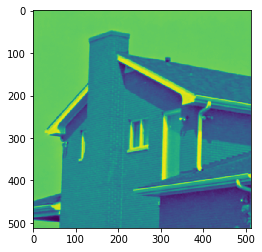

Iteration 03100  Loss 0.000042  PSNR 43.756853
3


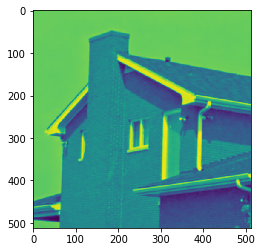

Iteration 03200  Loss 0.000039  PSNR 44.051557
3


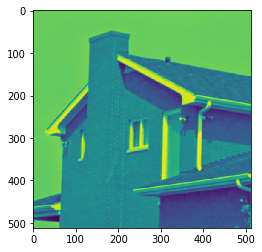

Iteration 03300  Loss 0.000039  PSNR 44.063744
3


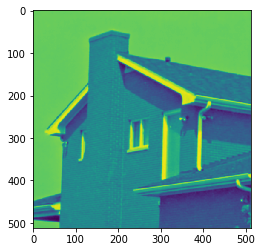

Iteration 03400  Loss 0.000041  PSNR 43.822520
3


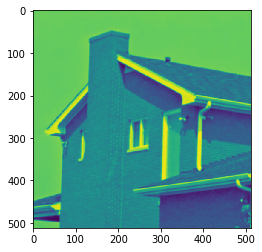

Iteration 03500  Loss 0.000038  PSNR 44.199548
3


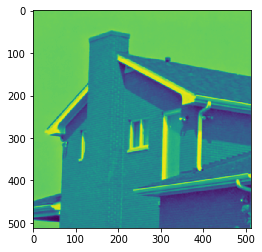

Iteration 03600  Loss 0.000041  PSNR 43.829678
3


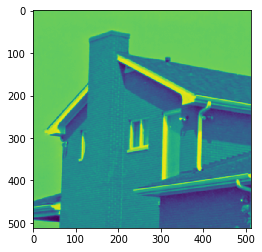

Iteration 03700  Loss 0.000054  PSNR 42.655141
3


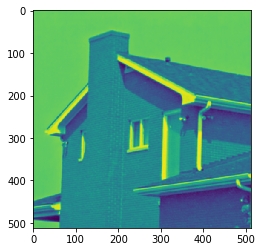

Iteration 03800  Loss 0.000035  PSNR 44.610945
3


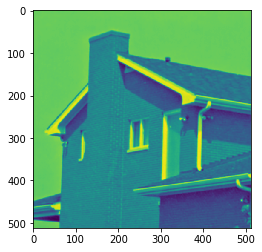

Iteration 03900  Loss 0.000034  PSNR 44.681085
3


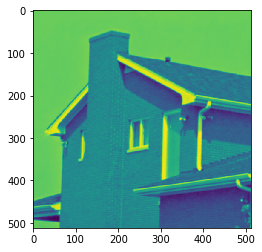

Iteration 04000  Loss 0.000030  PSNR 45.267803
3


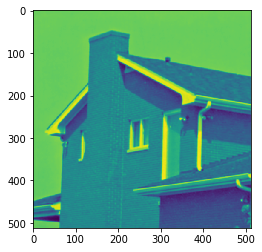

Iteration 04100  Loss 0.000033  PSNR 44.832190
3


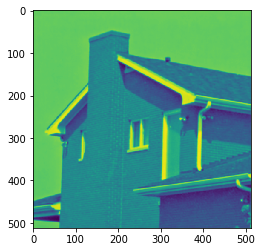

Iteration 04200  Loss 0.000031  PSNR 45.117596
3


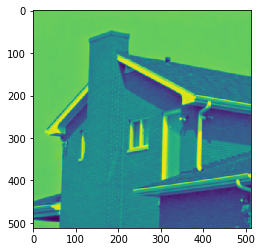

Iteration 04300  Loss 0.000031  PSNR 45.113259
3


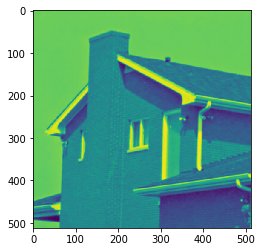

Iteration 04400  Loss 0.000027  PSNR 45.697896
3


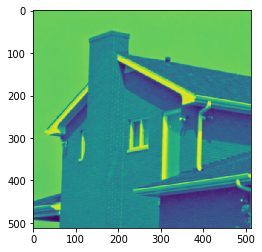

Iteration 04500  Loss 0.000026  PSNR 45.919158
3


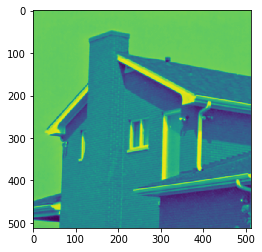

Iteration 04600  Loss 0.000029  PSNR 45.434488
3


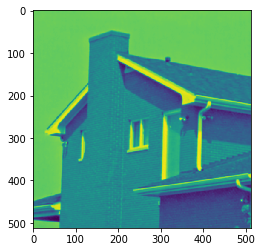

Iteration 04700  Loss 0.000025  PSNR 45.944665
3


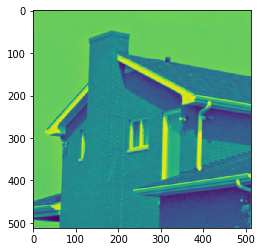

Iteration 04800  Loss 0.000024  PSNR 46.280039
3


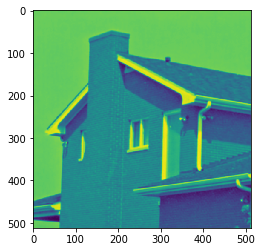

Iteration 04900  Loss 0.000028  PSNR 45.509864
3


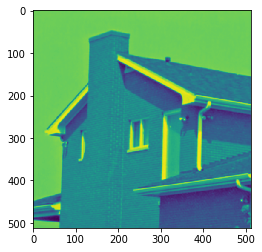

Iteration 05000  Loss 0.000023  PSNR 46.377267
3


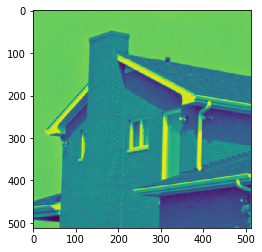

Iteration 05100  Loss 0.000023  PSNR 46.448676
3


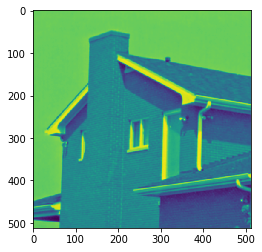

Iteration 05200  Loss 0.000037  PSNR 44.265558
3


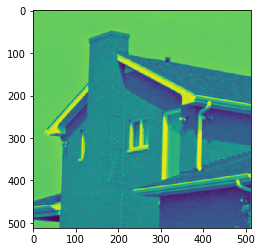

Iteration 05300  Loss 0.000021  PSNR 46.732184
3


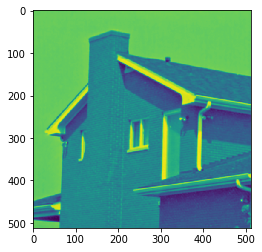

Iteration 05400  Loss 0.000020  PSNR 47.050873
3


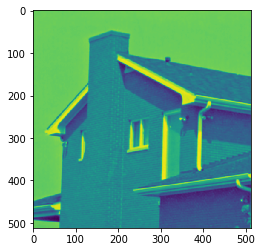

Iteration 05500  Loss 0.000022  PSNR 46.663909
3


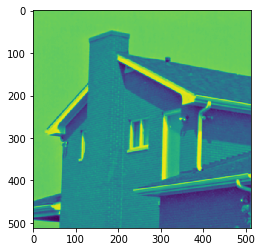

Iteration 05600  Loss 0.000020  PSNR 47.045174
3


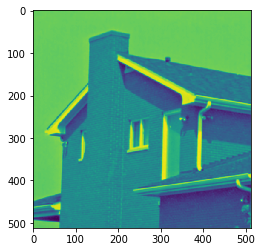

Iteration 05700  Loss 0.000024  PSNR 46.258859
3


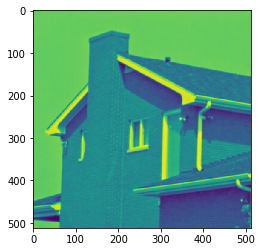

Iteration 05800  Loss 0.000022  PSNR 46.541549
3


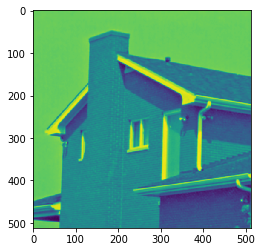

Iteration 05900  Loss 0.000017  PSNR 47.695362
3


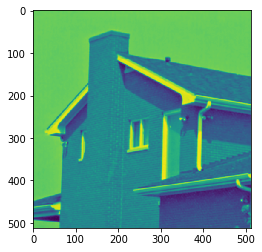

Iteration 06000  Loss 0.000017  PSNR 47.651413
3


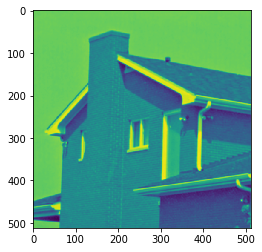

In [23]:
input_depth = 32
LR = 0.01 
num_iter = 6001
reg_noise_std = 0.03
if len(processed_img.shape)<4:
    c = 1
    w,h = processed_img.shape[1],processed_img.shape[2]
else:
    c = processed_img.shape[1]
    w,h = processed_img.shape[2], processed_img.shape[3]
    

model = skip(input_depth, c, 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [128] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='nearest', k_skip=1).type(dtype)
# print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)

    loss = mse(out * mask, processed_img)
    loss.backward()
    
    optimizer.step()
    PSNR.append(10 * math.log10(1 / loss.item()))   
    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR %f' % (i, loss.item(), 10 * math.log10(1 / loss.item())))
        out = out.detach().cpu().numpy()[0]
        plt.figure()
        print(len(out.shape))
        if len(out.shape)<=3:
            plt.imshow(out[0])
        else:
            plt.imshow(out.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

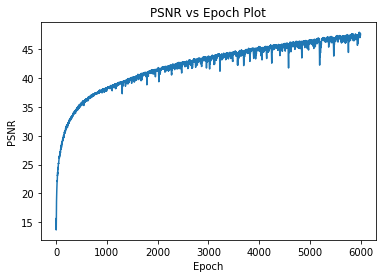

In [24]:
plt.title("PSNR vs Epoch Plot")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(PSNR)

In [25]:
PSNR[-1]

47.65141253184623

In [ ]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def act(activation_method = 'LeakyReLU'):
    if activation_method=='ReLU':
        return nn.ReLU()
    elif activation_method =='LeakyReLU':
        return nn.LeakyReLU(0.2, inplace=True)
    elif activation_method=='sigmoid':
        return nn.Sigmoid()
    else:
        return nn.Tanh()

def conv(in_f, out_f, kernel_size, stride=1): 
    res = []
    res.append(nn.ReflectionPad2d(int((kernel_size - 1) / 2)))
    res.append(nn.Conv2d(in_f, out_f, kernel_size, stride, padding=0))
    return nn.Sequential(*res)

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode, act_fun, ):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    for i in range(len(c_down)):
        deeper = nn.Sequential()
#         if i == 0:
#             deeper.add(conv(input_depth, c_down[i], k_down, 1))
#         else:
#             deeper.add(conv(input_depth, c_down[i], k_down, 2))
        deeper.add(conv(input_depth, c_down[i], k_down, 2))
        deeper.add(nn.BatchNorm2d(c_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(c_down[i], c_down[i], k_down))
        deeper.add(nn.BatchNorm2d(c_down[i]))
        deeper.add(act(act_fun))

#         temp_layers = []
#         temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
#         temp_layers.append(nn.Conv2d(input_depth, c_down[i], k_down, 2))
#         temp_layers.append(nn.BatchNorm2d(c_down[i]))
#         temp_layers.append(act(act_fun))
        
#         temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
#         temp_layers.append(nn.Conv2d(c_down[i], c_down[i], k_down, 1))
#         temp_layers.append(nn.BatchNorm2d(c_down[i]))
#         temp_layers.append(act(act_fun))
        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            deeper.add(deeper_main)
            deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), deeper))
            else:
                model_tmp.add(deeper)
            model_tmp.add(nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add(conv(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1))
            
        else:#last layer
            deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), deeper))
            else:
                model_tmp.add(deeper)
            model_tmp.add(nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add(conv(c_skip[i] + c_down[i], c_up[i], k_up, 1))

        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        model_tmp.add(conv(c_up[i], c_up[i], 1))
        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add(conv(c_up[0], c_out, 1))
    model.add(nn.Sigmoid())

    return model